In [1]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string
import re
from collections import Counter

# VEST OH 2020
---

## VEST Documentation

### Election Results

#### Sources
Election results from the Ohio Secretary of State (https://www.sos.state.oh.us/elections/election-results-and-data/). 

#### Processing Part 1
The following counties include adjustments to account for corporate annexations that are not specified below by precinct: Adams, Athens, Butler, Franklin, Guernsey, Montgomery, Stark, Tuscarawas, Warren, Wayne.

#### Processing Part 2 (unclear whether this is for election results, shapefiles, or both)
The following additional revisions were made to match the 2020 precinct boundaries:

- **Athens:** Adjust Athens 4-4/4-5, Nelsonville 1/2/3/4
- **Brown:** Adjust Perry Twp South/Villages
- **Butler:** Adjust Hamilton 22/24, Oxford 6/11, Trenton 5/7, West Chester 28/39
- **Champaign:** Adjust Union N/S
- **Clark:** Align New Carlisle, Springfield precincts with county maps
- **Crawford:** Move eastern Polk Twp from Galion 1B to western Polk Twp
- **Cuyahoga:** Adjust Olmsted Twp D/F/H
- **Delaware:** Adjust Berlin C/Delaware 3-F
- **Fairfield:** Adjust Greenfield B/Lancaster 2-A, Pickerington F/Violet B/Violet C
- **Greene:** Adjust Bath 277/Fairborn 226/Xenia 351
- **Hamilton:** Adjust Cleves A/Whitewater A, Colerain BB/F
- **Knox:** Adjust Clinton A/Mount Vernon 1-B, Clinton B/Mount Vernon 2-A
- **Lake:** Adjust Painesville A/K
- **Medina:** Adjust Wadsworth City 1-D/Sharon D, Wadsworth City 2-D/Twp C
- **Richland:** Adjust Ontario 3/4
- **Stark:** Adjust Canton 8-C/Plain 6, Canton 6-A/Plain 12
- **Summit:** Adjust Coventry D/G, Hudson 1-B/3-C, Springfield F/J
- **Warren:** Adjust Mason City Z/Union A, South Lebanon A/B

#### Races
G20PRERTRU - Donald J. Trump (Republican Party)  
G20PREDBID - Joseph R. Biden (Democratic Party)  
G20PRELJOR - Jo Jorgensen (Libertarian Party)  
G20PREGHAW - Howie Hawkins (Independent)  

### Shapefiles

#### Sources
Precinct shapefile from the U.S. Census Bureau's 2020 Redistricting Data Program final release. Note that some VTDs were relabeled to match precinct names and/or precinct codes in the November 2020 general election returns.

# Election Result Processing

## Get VEST file and FIPS dictionary ready

### Load in VEST file

In [2]:
vest_oh_20 = gp.read_file("./raw-from-source/VEST/oh_2020/oh_2020.shp")

In [3]:
vest_oh_20.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

<AxesSubplot:>

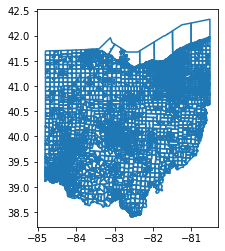

In [4]:
vest_oh_20.boundary.plot()

In [5]:
vest_oh_20.columns

Index(['STATEFP20', 'COUNTYFP20', 'VTDST20', 'PRECINCT20', 'GEOID20', 'NAME20',
       'G20PRERTRU', 'G20PREDBID', 'G20PRELJOR', 'G20PREGHAW', 'geometry'],
      dtype='object')

### Create a FIPs dictionary for OH

In [6]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Ohio"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

#Create the dictionary
oh_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

## Load and Clean Election Results

### Load Election Results

Cleaned the `statewideresultsbyprecinct.xlsx` file by hand, and created `statewideresultsbyprecinct_clean.csv`. No modifications were made to the election results. Unnecessary tabs were removed and column names were renamed to match VEST's manually. 

In [7]:
#Load in clean SOS file
elections_2020_raw = pd.read_excel("./raw-from-source/SOS/statewideresultsbyprecinct.xlsx",sheet_name="Master")

In [8]:
def clean_oh_import(dataframe):
    
    corrected_col_names = []
    for index in range(0,len(dataframe.columns)):
        col_name = dataframe.columns[index]
        col_name = col_name.replace("\n"," ")
        if "Unnamed" in col_name:
            corrected_col_names.append(corrected_col_names[index-1])
        else:
            corrected_col_names.append(col_name)
    dataframe.columns = corrected_col_names
    
    corrected_col_names = []
    for index in range(0,len(dataframe.columns)):
        col = dataframe.columns[index]
        first_row = dataframe.iloc[0,index]
        if (index > 7):
            new_column_name = col + " " + first_row 
            corrected_col_names.append(new_column_name)
        else:
            corrected_col_names.append(first_row)
    dataframe.columns = corrected_col_names
    
    dataframe = dataframe.iloc[3:,]
    return dataframe

In [9]:
elections_2020 = clean_oh_import(elections_2020_raw)

In [10]:
elections_2020["COUNTYFP"] = elections_2020["County Name"].map(oh_fips_dict).fillna("n/a")

<ipython-input-10-304ffd1f9ba5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elections_2020["COUNTYFP"] = elections_2020["County Name"].map(oh_fips_dict).fillna("n/a")


In [11]:
elections_2020["COUNTYFP"].unique()

array(['001', '003', '005', '007', '009', '011', '013', '015', '017',
       '019', '021', '023', '025', '027', '029', '031', '033', '035',
       '037', '039', '041', '043', '045', '047', '049', '051', '053',
       '055', '057', '059', '061', '063', '065', '067', '069', '071',
       '073', '075', '077', '079', '081', '083', '085', '087', '089',
       '091', '093', '095', '097', '099', '101', '103', '105', '107',
       '109', '111', '113', '115', '117', '119', '121', '123', '125',
       '127', '129', '131', '133', '135', '137', '139', '141', '143',
       '145', '147', '149', '151', '153', '155', '157', '159', '161',
       '163', '165', '167', '169', '171', '173', '175'], dtype=object)

In [12]:
filter_out_cols = [i for i in elections_2020.columns if ("Judge of the Court of Appeals - District" in i or "Member of the State Board of Education - District" in i or "WI" in i)]

In [13]:
elections_2020 = elections_2020[[i for i in elections_2020.columns if i not in filter_out_cols]]

In [14]:
# #Map to the correct FIP
# elections_2020["county"]=elections_2020["County Name"].map(oh_fips_dict).fillna(elections_2020["County Name"])

# #Print out the FIPS to make sure they all are in the correct format
# elections_2020["county"].unique()

## Look into split precincts

In [15]:
def get_level_dist(column_name):
    if "Representative to Congress" in column_name:
        level = "CON"
    elif "State Senator" in column_name:
        level = "SU"
    elif "State Representative" in column_name:
        level = "SL"
    else:
        raise ValueError
    return_val = re.findall("District \S{2}",column_name)    
    if (len(return_val)!=0):
        dist = return_val[0].split(" ")[1]
    else:
        raise ValueError
    return level,dist

In [16]:
def is_split_precinct(district_assignment_list):
    c = Counter([x[0] for x in district_assignment_list])
    greater_than_one = {x:[y[1] for y in district_assignment_list if y[0]==x] for x, count in c.items() if count > 1}
    if len(greater_than_one)==0:
        return 0
    else:
        return greater_than_one

In [17]:
district_cols = [i for i in elections_2020.columns if "District" in i]
elections_2020_districts = elections_2020[['COUNTYFP','Precinct Name','Precinct Code']+district_cols]

In [18]:
precinct_mapping_dict = {}
split_precincts_list = {}
for index,row in elections_2020_districts.iterrows():
    precinct_list = []
    for contest in district_cols:
        if(row[contest]!=0):
            precinct_info = get_level_dist(contest)
            if precinct_info not in precinct_list:
                precinct_list.append(get_level_dist(contest))
    is_split = is_split_precinct(precinct_list)
    if (is_split):
        split_precincts_list[row["COUNTYFP"]+"-"+row["Precinct Code"]]=is_split
    precinct_mapping_dict[row["COUNTYFP"]+"-"+row["Precinct Code"]]=precinct_list


In [19]:
split_precincts_list

{'011-AAR': {'SL': ['82', '84']},
 '017-ACG': {'SL': ['51', '53']},
 '017-AGC': {'SL': ['51', '53']},
 '017-AGH': {'SL': ['51', '53']},
 '017-AIF': {'SL': ['51', '53']},
 '035-AEI': {'CON': ['09', '16']},
 '035-AHU': {'SL': ['09', '12']},
 '035-ALT': {'SL': ['09', '11']},
 '035-AWR': {'SL': ['08', '10']},
 '035-AZU': {'SL': ['10', '13']},
 '035-BBR': {'SL': ['10', '15']},
 '035-BCI': {'SL': ['13', '15']},
 '035-BCZ': {'SL': ['10', '15']},
 '035-BEH': {'CON': ['09', '11']},
 '035-BFB': {'CON': ['09', '11']},
 '035-BFK': {'CON': ['09', '11']},
 '041-AEH': {'SL': ['67', '68']},
 '041-AEM': {'SL': ['67', '68']},
 '041-AFW': {'SL': ['67', '68']},
 '043-ACF': {'CON': ['04', '09']},
 '045-ACF': {'SL': ['77', '78']},
 '047-AAU': {'CON': ['10', '15']},
 '047-ABK': {'CON': ['10', '15']},
 '049-AAO': {'CON': ['03', '15'], 'SL': ['17', '18']},
 '049-AAS': {'CON': ['03', '15']},
 '049-ABL': {'SL': ['18', '25']},
 '049-ABX': {'CON': ['03', '15']},
 '049-ABY': {'CON': ['03', '15']},
 '049-ABZ': {'CON

In [20]:
precinct_mapping_dict

{'001-AAA': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-AAB': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-AAD': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-AAE': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-AAG': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-AAI': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-AAK': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-AAN': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-AAP': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-AAR': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-AAS': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-AAT': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-AAU': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-AAW': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-AAY': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-AAZ': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-ABA': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-ABC': [('CON', '02'), ('S

## Rename Columns

In [21]:
elections_2020.columns

keep_names = ['County Name','Precinct Name','Precinct Code','Region Name','Media Market','Registered Voters','Ballots Counted','Official Voter Turnout','county','UNIQUE_ID','COUNTYFP']

In [22]:
def get_race(contest):
    if "Justice of the Supreme Court" in contest:
        level = "SSC"
        if "Kennedy" in contest or "O'Donnell" in contest:
            level = "SSCK"
        else:
            level = "SSCF"
    elif "President" in contest:
        level = "PRE"
    elif ("Representative to Congress" in contest or "State Senator" in contest or "State Representative" in contest):
        contest_info = get_level_dist(contest)
        level = contest_info[0]+contest_info[1]
    else:
          raise ValueError
    return level

"Although elections for the Ohio Supreme Court are officially nonpartisan, they are preceded by a partisan primary."

In [23]:
def get_party(contest):
    if contest == "State Representative - District 30  Tom Roll":
        return "I"
    if "Justice of the Supreme Court Term" in contest:
        if "Sharon L. Kennedy" in contest:
            return "R"
        elif "John P. O'Donnell" in contest:
            return "D"
        elif "Jennifer Brunner" in contest:
            return "D"
        elif "Judi French" in contest:
            return "R"
        else:
            print(contest)
            raise ValueError
    return_val = re.findall("\(\S\)",contest)   
    if (len(return_val)!=0):
        party = return_val[0][1]
        return party
    else:
        print(contest)
        raise ValueError

In [24]:
def get_name(contest):
    contest = contest.upper()
    contest = contest.replace("'","")
    if ("(") in contest.split(" ")[-1]:
        second_to_last = contest.split(" ")[-2]
        #second_to_last = second_to_last.replace("'","")
        if second_to_last in ["JR","III"]:
            third_to_last = contest.split(" ")[-3]
            #third_to_last = third_to_last.replace("'","")
            return third_to_last[0:3]
        else:
            return second_to_last[0:3]
    else:
        return contest.split(" ")[-1][0:3] 

In [25]:
contest_name_change_dict = {
 'President and Vice President  Joseph R. Biden and Kamala D. Harris (D)':'G20PREDBID',
 'President and Vice President  Howie Hawkins and Angela Walker':'G20PREGHAW',
 'President and Vice President  Jo Jorgensen and Spike Cohen (L)':'G20PRELJOR',
 'President and Vice President  Donald J. Trump and Michael R. Pence (R)':'G20PRERTRU',
}

In [26]:
for contest in elections_2020.columns:
    if contest not in keep_names and "President" not in contest:
        contest_name_change_dict[contest] = "G"+get_race(contest)+get_party(contest)+get_name(contest)

In [27]:
df = pd.DataFrame([(v, k) for k, v in contest_name_change_dict.items()], columns=['Candidate', 'Column'])
# Store the data into a csv file
df.to_csv('./cand_dicts/oh_gen_20_cong_prec.csv', sep=',')

In [28]:
elections_2020.rename(columns=contest_name_change_dict,inplace=True)

In [29]:
list(elections_2020.columns)

['County Name',
 'Precinct Name',
 'Precinct Code',
 'Region Name',
 'Media Market',
 'Registered Voters',
 'Ballots Counted',
 'Official Voter Turnout',
 'G20PREDBID',
 'G20PREGHAW',
 'G20PRELJOR',
 'G20PRERTRU',
 'GCON01RCHA',
 'GCON01LKAH',
 'GCON01DSCH',
 'GCON02DCAS',
 'GCON02RWEN',
 'GCON03DBEA',
 'GCON03RRIC',
 'GCON04DFRE',
 'GCON04RJOR',
 'GCON04LPER',
 'GCON05RLAT',
 'GCON05DRUB',
 'GCON06RJOH',
 'GCON06DROB',
 'GCON07RGIB',
 'GCON07LLAP',
 'GCON07DPOT',
 'GCON08RDAV',
 'GCON08DENO',
 'GCON09DKAP',
 'GCON09RWEB',
 'GCON10DTIM',
 'GCON10RTUR',
 'GCON11DFUD',
 'GCON11RGOR',
 'GCON12RBAL',
 'GCON12DSHE',
 'GCON12LSTE',
 'GCON13LFRI',
 'GCON13RHAG',
 'GCON13DRYA',
 'GCON14RJOY',
 'GCON14DMUE',
 'GCON15DNEW',
 'GCON15RSTI',
 'GCON16DGOD',
 'GCON16RGON',
 'GSU02RGAV',
 'GSU02DODO',
 'GSU04RLAN',
 'GSU04DWYE',
 'GSU06RANT',
 'GSU06DFOG',
 'GSU08RBLE',
 'GSU08DBRO',
 'GSU10DBAL',
 'GSU10RHAC',
 'GSU12RHUF',
 'GSU12DPOL',
 'GSU14RJOH',
 'GSU14DOTT',
 'GSU16RKUN',
 'GSU16DLET',
 'GSU18

### Filter Down to Relevant Columns

In [30]:
keeper_columns = ['County Name','Precinct Name','Precinct Code','Region Name','Media Market','Registered Voters','Ballots Counted','Official Voter Turnout','COUNTYFP']
us_house_contests = [i for i in list(elections_2020.columns) if "GCON" in i]

In [31]:
elections_2020 = elections_2020[keeper_columns+us_house_contests]

### Compare Precinct Totals

In [32]:
elections_2020["UNIQUE_ID"] = elections_2020["COUNTYFP"]+"-"+elections_2020["Precinct Code"]
vest_oh_20["UNIQUE_ID"] = vest_oh_20["COUNTYFP20"]+"-"+vest_oh_20["PRECINCT20"]

In [33]:
#Confirm unique IDs are unique
print(elections_2020["UNIQUE_ID"].value_counts(dropna=False))
print(vest_oh_20["UNIQUE_ID"].value_counts(dropna=False))

099-AJN    1
035-DEK    1
011-ABC    1
035-BJG    1
153-AII    1
          ..
081-ABO    1
073-ABE    1
113-AKV    1
017-AFN    1
037-AAG    1
Name: UNIQUE_ID, Length: 8933, dtype: int64
099-AJN    1
049-AFC    1
057-AIZ    1
041-ACT    1
151-AOY    1
          ..
095-AGD    1
081-ABO    1
073-ABE    1
113-AKV    1
037-AAG    1
Name: UNIQUE_ID, Length: 8941, dtype: int64


In [34]:
global attempt_one
attempt_one = pd.merge(vest_oh_20,elections_2020,how="outer",on="UNIQUE_ID",indicator=True)
print(attempt_one["_merge"].value_counts())

vest_only = attempt_one[attempt_one["_merge"]=="left_only"]
elections_only = attempt_one[attempt_one["_merge"]=="right_only"]

both          8933
left_only        8
right_only       0
Name: _merge, dtype: int64


In [35]:
attempt_one.columns

Index(['STATEFP20', 'COUNTYFP20', 'VTDST20', 'PRECINCT20', 'GEOID20', 'NAME20',
       'G20PRERTRU', 'G20PREDBID', 'G20PRELJOR', 'G20PREGHAW', 'geometry',
       'UNIQUE_ID', 'County Name', 'Precinct Name', 'Precinct Code',
       'Region Name', 'Media Market', 'Registered Voters', 'Ballots Counted',
       'Official Voter Turnout', 'COUNTYFP', 'GCON01RCHA', 'GCON01LKAH',
       'GCON01DSCH', 'GCON02DCAS', 'GCON02RWEN', 'GCON03DBEA', 'GCON03RRIC',
       'GCON04DFRE', 'GCON04RJOR', 'GCON04LPER', 'GCON05RLAT', 'GCON05DRUB',
       'GCON06RJOH', 'GCON06DROB', 'GCON07RGIB', 'GCON07LLAP', 'GCON07DPOT',
       'GCON08RDAV', 'GCON08DENO', 'GCON09DKAP', 'GCON09RWEB', 'GCON10DTIM',
       'GCON10RTUR', 'GCON11DFUD', 'GCON11RGOR', 'GCON12RBAL', 'GCON12DSHE',
       'GCON12LSTE', 'GCON13LFRI', 'GCON13RHAG', 'GCON13DRYA', 'GCON14RJOY',
       'GCON14DMUE', 'GCON15DNEW', 'GCON15RSTI', 'GCON16DGOD', 'GCON16RGON',
       '_merge'],
      dtype='object')

In [36]:
#Confirm these are all zero-vote races
races =["UNIQUE_ID"]

for val in ['G20PRERTRU', 'G20PREDBID', 'G20PRELJOR',
       'G20PREGHAW']:
    races.append(val)

print((vest_only[races]))

     UNIQUE_ID  G20PRERTRU  G20PREDBID  G20PRELJOR  G20PREGHAW
814    093-ZZZ           0           0           0           0
982    123-ZZZ           0           0           0           0
2924   095-ZZZ           0           0           0           0
3674   043-ZZZ           0           0           0           0
4389   085-ZZZ           0           0           0           0
4565   035-ZZZ           0           0           0           0
5357   133-ZZZ           0           0           0           0
7951   007-ZZZ           0           0           0           0


## Perform Splits

In [37]:
def return_con_splits(split_dict):
    for val in split_dict.keys():
        if 'CON' in val:
            return split_dict['CON']

In [38]:
con_splits_dict = {i:return_con_splits(split_precincts_list[i]) for i in split_precincts_list.keys() if return_con_splits(split_precincts_list[i]) != None }

#### Create dictionary of where the splits should occur

In [39]:
con_splits_dict

{'035-AEI': ['09', '16'],
 '035-BEH': ['09', '11'],
 '035-BFB': ['09', '11'],
 '035-BFK': ['09', '11'],
 '043-ACF': ['04', '09'],
 '047-AAU': ['10', '15'],
 '047-ABK': ['10', '15'],
 '049-AAO': ['03', '15'],
 '049-AAS': ['03', '15'],
 '049-ABX': ['03', '15'],
 '049-ABY': ['03', '15'],
 '049-ABZ': ['03', '15'],
 '049-ACB': ['03', '15'],
 '049-ACC': ['03', '15'],
 '049-ACD': ['03', '15'],
 '049-ADJ': ['03', '12'],
 '049-ADX': ['03', '12'],
 '049-AEB': ['03', '12'],
 '049-AEF': ['03', '12'],
 '049-AGH': ['03', '12'],
 '049-AGI': ['03', '12'],
 '049-AGW': ['03', '15'],
 '049-AGX': ['03', '15'],
 '049-AGZ': ['03', '15'],
 '049-AHA': ['03', '15'],
 '049-AHC': ['03', '15'],
 '049-AHT': ['03', '15'],
 '049-AHU': ['03', '15'],
 '049-AHV': ['03', '15'],
 '049-AID': ['03', '15'],
 '049-AIE': ['03', '12'],
 '049-AII': ['03', '12'],
 '049-AKK': ['03', '15'],
 '049-AKL': ['03', '15'],
 '049-AKO': ['03', '15'],
 '049-AKR': ['03', '15'],
 '049-AMN': ['03', '15'],
 '049-AND': ['12', '15'],
 '049-ANE': 

#### Load in the shapefile

In [40]:
oh_con_districts = gp.read_file("./raw-from-source/District_Shapefiles/cb_2018_us_cd116_500k/cb_2018_us_cd116_500k.shp")

In [41]:
oh_con_districts = oh_con_districts[oh_con_districts["STATEFP"]=="39"]

In [42]:
oh_con_districts

,STATEFP,CD116FP,AFFGEOID,GEOID,LSAD,CDSESSN,ALAND,AWATER,geometry
51,39,10,5001600US3910,3910,C2,116,2925748848,15947647,"POLYGON ((-84.48537 39.91849, -84.44959 39.919..."
97,39,12,5001600US3912,3912,C2,116,5884212463,76786970,"POLYGON ((-83.24941 40.31577, -83.24957 40.339..."
98,39,16,5001600US3916,3916,C2,116,3121894599,31141190,"POLYGON ((-82.12933 40.99181, -82.07884 40.991..."
137,39,14,5001600US3914,3914,C2,116,5064219099,3730283485,"POLYGON ((-81.67044 41.31388, -81.64870 41.313..."
146,39,02,5001600US3902,3902,C2,116,8344038308,77170483,"POLYGON ((-84.57394 39.21211, -84.57276 39.212..."
200,39,13,5001600US3913,3913,C2,116,2315287784,70792303,"POLYGON ((-81.64999 41.00162, -81.64447 41.003..."
232,39,03,5001600US3903,3903,C2,116,590732885,11274048,"POLYGON ((-83.17385 39.97542, -83.17361 39.975..."
233,39,04,5001600US3904,3904,C2,116,12083214953,121559316,"POLYGON ((-84.57669 40.51716, -84.57640 40.517..."
234,39,15,5001600US3915,3915,C2,116,12273402700,99789977,"POLYGON ((-84.00373 39.28847, -84.00370 39.288..."
235,39,08,5001600US3908,3908,C2,116,6344114806,42726671,"POLYGON ((-84.81935 39.30945, -84.81845 39.348..."


In [43]:
final_races = ['GCON01RCHA','GCON01LKAH',
       'GCON01DSCH', 'GCON02DCAS', 'GCON02RWEN', 'GCON03DBEA', 'GCON03RRIC',
       'GCON04DFRE', 'GCON04RJOR', 'GCON04LPER', 'GCON05RLAT', 'GCON05DRUB',
       'GCON06RJOH', 'GCON06DROB', 'GCON07RGIB', 'GCON07LLAP', 'GCON07DPOT',
       'GCON08RDAV', 'GCON08DENO', 'GCON09DKAP', 'GCON09RWEB', 'GCON10DTIM',
       'GCON10RTUR', 'GCON11DFUD', 'GCON11RGOR', 'GCON12RBAL', 'GCON12DSHE',
       'GCON12LSTE', 'GCON13LFRI', 'GCON13RHAG', 'GCON13DRYA', 'GCON14RJOY',
       'GCON14DMUE', 'GCON15DNEW', 'GCON15RSTI', 'GCON16DGOD', 'GCON16RGON']

In [44]:
for val in final_races:
    attempt_one[val] = attempt_one[val].fillna(0)
    attempt_one[val] = attempt_one[val].astype(int)
    print(val, sum(attempt_one[val]))

GCON01RCHA 199560
GCON01LKAH 13692
GCON01DSCH 172022
GCON02DCAS 146781
GCON02RWEN 230430
GCON03DBEA 227420
GCON03RRIC 93569
GCON04DFRE 101897
GCON04RJOR 235875
GCON04LPER 9854
GCON05RLAT 257019
GCON05DRUB 120962
GCON06RJOH 249130
GCON06DROB 85661
GCON07RGIB 236607
GCON07LLAP 11671
GCON07DPOT 102271
GCON08RDAV 246277
GCON08DENO 110766
GCON09DKAP 190328
GCON09RWEB 111385
GCON10DTIM 151976
GCON10RTUR 212972
GCON11DFUD 242098
GCON11RGOR 60323
GCON12RBAL 241790
GCON12DSHE 182847
GCON12LSTE 13035
GCON13LFRI 8522
GCON13RHAG 148648
GCON13DRYA 173631
GCON14RJOY 238864
GCON14DMUE 158586
GCON15DNEW 140183
GCON15RSTI 243103
GCON16DGOD 144071
GCON16RGON 247335


In [45]:
def cd_splits(cd_list,level,old_name):
    global attempt_one
    full_shape = attempt_one.loc[attempt_one["UNIQUE_ID"]==old_name]
    #print(old_name,"->"," & ".join(new_id_list))
    for index in range(0,len(cd_list)):
        cd = oh_con_districts.loc[oh_con_districts["CD116FP"]==cd_list[index]]
        new_prec = gp.overlay(full_shape, cd, how='intersection',keep_geom_type=True)
        if(new_prec.empty):
            print("***Issue merging SLDL: ",cd_list[index],"and prec:",old_name,"***")
            ax = full_shape.plot()
            cd.boundary.plot(ax=ax, color="red")
            xlim = ([full_shape.total_bounds[0],  full_shape.total_bounds[2]])
            ylim = ([full_shape.total_bounds[1],  full_shape.total_bounds[3]])
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
        new_prec = new_prec[list(attempt_one.columns)]
        for column in new_prec:
            if column in final_races and cd_list[index] not in column:
                new_prec.loc[0:,column] = 0 
        new_prec["UNIQUE_ID"]=old_name+"-("+level+"-"+cd_list[index]+")"
        attempt_one=attempt_one.append(new_prec)
        attempt_one.reset_index(drop=True,inplace=True)        
    #Remove the precinct that was split
    attempt_one=attempt_one[attempt_one["UNIQUE_ID"]!=old_name]
    attempt_one.reset_index(drop=True,inplace=True)

***Issue merging SLDL:  15 and prec: 049-AGW ***


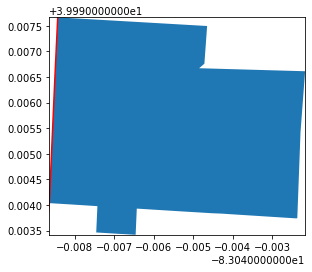

In [46]:
#Re-introduce the column from above

# Iterate over dataframe, get the results where splits will need to happen

for val in attempt_one["UNIQUE_ID"]:
    cd_list = []
    if val in con_splits_dict.keys():
#         print(val)
#         print(con_splits_dict[val])
        #How we will actually call it
        cd_splits(con_splits_dict[val],"CON",val)

In [47]:
pd.options.display.max_columns = 999

display(attempt_one[attempt_one["UNIQUE_ID"]=="049-AZM-(CON-15)"])
display(attempt_one[attempt_one["UNIQUE_ID"]=="049-AZM-(CON-03)"])

,STATEFP20,COUNTYFP20,VTDST20,PRECINCT20,GEOID20,NAME20,G20PRERTRU,G20PREDBID,G20PRELJOR,G20PREGHAW,geometry,UNIQUE_ID,County Name,Precinct Name,Precinct Code,Region Name,Media Market,Registered Voters,Ballots Counted,Official Voter Turnout,COUNTYFP,GCON01RCHA,GCON01LKAH,GCON01DSCH,GCON02DCAS,GCON02RWEN,GCON03DBEA,GCON03RRIC,GCON04DFRE,GCON04RJOR,GCON04LPER,GCON05RLAT,GCON05DRUB,GCON06RJOH,GCON06DROB,GCON07RGIB,GCON07LLAP,GCON07DPOT,GCON08RDAV,GCON08DENO,GCON09DKAP,GCON09RWEB,GCON10DTIM,GCON10RTUR,GCON11DFUD,GCON11RGOR,GCON12RBAL,GCON12DSHE,GCON12LSTE,GCON13LFRI,GCON13RHAG,GCON13DRYA,GCON14RJOY,GCON14DMUE,GCON15DNEW,GCON15RSTI,GCON16DGOD,GCON16RGON,_merge
9084,39,049,025AZM,AZM,39049025AZM,JACKSON-A,431,161,7,0,"MULTIPOLYGON (((-83.06169 39.88387, -83.06124 ...",049-AZM-(CON-15),Franklin,JACKSON-A,AZM,Central,Columbus,830,600,0.722892,049,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,98,333,0,0,both


,STATEFP20,COUNTYFP20,VTDST20,PRECINCT20,GEOID20,NAME20,G20PRERTRU,G20PREDBID,G20PRELJOR,G20PREGHAW,geometry,UNIQUE_ID,County Name,Precinct Name,Precinct Code,Region Name,Media Market,Registered Voters,Ballots Counted,Official Voter Turnout,COUNTYFP,GCON01RCHA,GCON01LKAH,GCON01DSCH,GCON02DCAS,GCON02RWEN,GCON03DBEA,GCON03RRIC,GCON04DFRE,GCON04RJOR,GCON04LPER,GCON05RLAT,GCON05DRUB,GCON06RJOH,GCON06DROB,GCON07RGIB,GCON07LLAP,GCON07DPOT,GCON08RDAV,GCON08DENO,GCON09DKAP,GCON09RWEB,GCON10DTIM,GCON10RTUR,GCON11DFUD,GCON11RGOR,GCON12RBAL,GCON12DSHE,GCON12LSTE,GCON13LFRI,GCON13RHAG,GCON13DRYA,GCON14RJOY,GCON14DMUE,GCON15DNEW,GCON15RSTI,GCON16DGOD,GCON16RGON,_merge
9083,39,049,025AZM,AZM,39049025AZM,JACKSON-A,431,161,7,0,"MULTIPOLYGON (((-83.11989 39.89046, -83.11987 ...",049-AZM-(CON-03),Franklin,JACKSON-A,AZM,Central,Columbus,830,600,0.722892,049,0,0,0,0,0,37,106,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,both


## Check the column totals

In [48]:
tot_sum = 0
for val in final_races:
    print(val, sum(attempt_one[val]))
    tot_sum += sum(attempt_one[val])

GCON01RCHA 199560
GCON01LKAH 13692
GCON01DSCH 172022
GCON02DCAS 146781
GCON02RWEN 230430
GCON03DBEA 227420
GCON03RRIC 93569
GCON04DFRE 101897
GCON04RJOR 235875
GCON04LPER 9854
GCON05RLAT 257019
GCON05DRUB 120962
GCON06RJOH 249130
GCON06DROB 85661
GCON07RGIB 236607
GCON07LLAP 11671
GCON07DPOT 102271
GCON08RDAV 246277
GCON08DENO 110766
GCON09DKAP 190328
GCON09RWEB 111385
GCON10DTIM 151976
GCON10RTUR 212972
GCON11DFUD 242098
GCON11RGOR 60323
GCON12RBAL 241790
GCON12DSHE 182847
GCON12LSTE 13035
GCON13LFRI 8522
GCON13RHAG 148648
GCON13DRYA 173631
GCON14RJOY 238864
GCON14DMUE 158586
GCON15DNEW 140178
GCON15RSTI 243102
GCON16DGOD 144071
GCON16RGON 247335


### Election differences

15 Joel Newby (D) -> This file 140178 -> State 140183  
15 Steve Stivers (R) -> This file 243102 -> State 243103

Note: These occur due to the intersection issue above, since these are only 6 total votes, they will be removed from the file

### To-Do:

- ~Clean up the columns~
- ~Check the column totals~
- ~Add in a CON_DIST column~

## Add in a CON_DIST column

In [49]:
def contains_con(dist_list):
    print("Calling on ", dist_list)
    for dist_tuple in dist_list:
        print("Call on ", dist_tuple)
        if dist_tuple[0] == "CON":
            print("Found the CON")
            return dist_tuple[1]

In [50]:
check_list = {i:contains_con(precinct_mapping_dict[i]) for i in precinct_mapping_dict.keys()}

Calling on  [('CON', '02'), ('SU', '14'), ('SL', '90')]
Call on  ('CON', '02')
Found the CON
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '90')]
Call on  ('CON', '02')
Found the CON
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '90')]
Call on  ('CON', '02')
Found the CON
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '90')]
Call on  ('CON', '02')
Found the CON
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '90')]
Call on  ('CON', '02')
Found the CON
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '90')]
Call on  ('CON', '02')
Found the CON
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '90')]
Call on  ('CON', '02')
Found the CON
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '90')]
Call on  ('CON', '02')
Found the CON
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '90')]
Call on  ('CON', '02')
Found the CON
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '90')]
Call on  ('CON', '02')
Found the CON
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '90')]
Call on  ('CON

Calling on  [('CON', '06'), ('SU', '30'), ('SL', '95')]
Call on  ('CON', '06')
Found the CON
Calling on  [('CON', '06'), ('SU', '30'), ('SL', '95')]
Call on  ('CON', '06')
Found the CON
Calling on  [('CON', '06'), ('SU', '30'), ('SL', '95')]
Call on  ('CON', '06')
Found the CON
Calling on  [('CON', '06'), ('SU', '30'), ('SL', '95')]
Call on  ('CON', '06')
Found the CON
Calling on  [('CON', '06'), ('SU', '30'), ('SL', '95')]
Call on  ('CON', '06')
Found the CON
Calling on  [('CON', '06'), ('SU', '30'), ('SL', '96')]
Call on  ('CON', '06')
Found the CON
Calling on  [('CON', '06'), ('SU', '30'), ('SL', '95')]
Call on  ('CON', '06')
Found the CON
Calling on  [('CON', '06'), ('SU', '30'), ('SL', '95')]
Call on  ('CON', '06')
Found the CON
Calling on  [('CON', '06'), ('SU', '30'), ('SL', '95')]
Call on  ('CON', '06')
Found the CON
Calling on  [('CON', '06'), ('SU', '30'), ('SL', '96')]
Call on  ('CON', '06')
Found the CON
Calling on  [('CON', '06'), ('SU', '30'), ('SL', '96')]
Call on  ('CON

Calling on  [('CON', '08'), ('SU', '04'), ('SL', '51')]
Call on  ('CON', '08')
Found the CON
Calling on  [('CON', '08'), ('SU', '04'), ('SL', '51')]
Call on  ('CON', '08')
Found the CON
Calling on  [('CON', '08'), ('SU', '04'), ('SL', '51')]
Call on  ('CON', '08')
Found the CON
Calling on  [('CON', '08'), ('SU', '04'), ('SL', '51')]
Call on  ('CON', '08')
Found the CON
Calling on  [('CON', '08'), ('SU', '04'), ('SL', '51')]
Call on  ('CON', '08')
Found the CON
Calling on  [('CON', '08'), ('SU', '04'), ('SL', '51')]
Call on  ('CON', '08')
Found the CON
Calling on  [('CON', '08'), ('SU', '04'), ('SL', '51')]
Call on  ('CON', '08')
Found the CON
Calling on  [('CON', '08'), ('SU', '04'), ('SL', '51')]
Call on  ('CON', '08')
Found the CON
Calling on  [('CON', '08'), ('SU', '04'), ('SL', '51')]
Call on  ('CON', '08')
Found the CON
Calling on  [('CON', '08'), ('SU', '04'), ('SL', '51')]
Call on  ('CON', '08')
Found the CON
Calling on  [('CON', '08'), ('SU', '04'), ('SL', '51')]
Call on  ('CON

Calling on  [('CON', '02'), ('SU', '14'), ('SL', '66')]
Call on  ('CON', '02')
Found the CON
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '66')]
Call on  ('CON', '02')
Found the CON
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '66')]
Call on  ('CON', '02')
Found the CON
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '65')]
Call on  ('CON', '02')
Found the CON
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '65')]
Call on  ('CON', '02')
Found the CON
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '65')]
Call on  ('CON', '02')
Found the CON
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '65')]
Call on  ('CON', '02')
Found the CON
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '65')]
Call on  ('CON', '02')
Found the CON
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '65')]
Call on  ('CON', '02')
Found the CON
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '65')]
Call on  ('CON', '02')
Found the CON
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '65')]
Call on  ('CON

Found the CON
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '65')]
Call on  ('CON', '02')
Found the CON
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '65')]
Call on  ('CON', '02')
Found the CON
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '66')]
Call on  ('CON', '02')
Found the CON
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '66')]
Call on  ('CON', '02')
Found the CON
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '66')]
Call on  ('CON', '02')
Found the CON
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '65')]
Call on  ('CON', '02')
Found the CON
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '65')]
Call on  ('CON', '02')
Found the CON
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '65')]
Call on  ('CON', '02')
Found the CON
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '66')]
Call on  ('CON', '02')
Found the CON
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '66')]
Call on  ('CON', '02')
Found the CON
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '66')]


Found the CON
Calling on  [('CON', '11'), ('SL', '11')]
Call on  ('CON', '11')
Found the CON
Calling on  [('CON', '11'), ('SL', '11')]
Call on  ('CON', '11')
Found the CON
Calling on  [('CON', '11'), ('SL', '11')]
Call on  ('CON', '11')
Found the CON
Calling on  [('CON', '11'), ('SL', '11')]
Call on  ('CON', '11')
Found the CON
Calling on  [('CON', '11'), ('SL', '11')]
Call on  ('CON', '11')
Found the CON
Calling on  [('CON', '11'), ('SL', '11')]
Call on  ('CON', '11')
Found the CON
Calling on  [('CON', '11'), ('SL', '11')]
Call on  ('CON', '11')
Found the CON
Calling on  [('CON', '11'), ('SL', '11')]
Call on  ('CON', '11')
Found the CON
Calling on  [('CON', '11'), ('SL', '10')]
Call on  ('CON', '11')
Found the CON
Calling on  [('CON', '11'), ('SL', '11')]
Call on  ('CON', '11')
Found the CON
Calling on  [('CON', '11'), ('SL', '11')]
Call on  ('CON', '11')
Found the CON
Calling on  [('CON', '11'), ('SL', '11')]
Call on  ('CON', '11')
Found the CON
Calling on  [('CON', '11'), ('SL', '11

Call on  ('CON', '16')
Found the CON
Calling on  [('CON', '16'), ('SL', '14')]
Call on  ('CON', '16')
Found the CON
Calling on  [('CON', '16'), ('SL', '14')]
Call on  ('CON', '16')
Found the CON
Calling on  [('CON', '16'), ('SL', '14')]
Call on  ('CON', '16')
Found the CON
Calling on  [('CON', '16'), ('SL', '14')]
Call on  ('CON', '16')
Found the CON
Calling on  [('CON', '16'), ('SL', '14')]
Call on  ('CON', '16')
Found the CON
Calling on  [('CON', '16'), ('SL', '14')]
Call on  ('CON', '16')
Found the CON
Calling on  [('CON', '16'), ('SL', '14')]
Call on  ('CON', '16')
Found the CON
Calling on  [('CON', '16'), ('SL', '14')]
Call on  ('CON', '16')
Found the CON
Calling on  [('CON', '16'), ('SL', '14')]
Call on  ('CON', '16')
Found the CON
Calling on  [('CON', '16'), ('SL', '14')]
Call on  ('CON', '16')
Found the CON
Calling on  [('CON', '16'), ('SU', '24'), ('SL', '16')]
Call on  ('CON', '16')
Found the CON
Calling on  [('CON', '16'), ('SU', '24'), ('SL', '16')]
Call on  ('CON', '16')
F

Call on  ('CON', '11')
Found the CON
Calling on  [('CON', '11'), ('SL', '12')]
Call on  ('CON', '11')
Found the CON
Calling on  [('CON', '11'), ('SL', '12')]
Call on  ('CON', '11')
Found the CON
Calling on  [('CON', '11'), ('SL', '12')]
Call on  ('CON', '11')
Found the CON
Calling on  [('CON', '11'), ('SU', '24'), ('SL', '06')]
Call on  ('CON', '11')
Found the CON
Calling on  [('CON', '11'), ('SU', '24'), ('SL', '06')]
Call on  ('CON', '11')
Found the CON
Calling on  [('CON', '08'), ('SU', '12'), ('SL', '84')]
Call on  ('CON', '08')
Found the CON
Calling on  [('CON', '08'), ('SU', '12'), ('SL', '84')]
Call on  ('CON', '08')
Found the CON
Calling on  [('CON', '08'), ('SU', '12'), ('SL', '84')]
Call on  ('CON', '08')
Found the CON
Calling on  [('CON', '08'), ('SU', '12'), ('SL', '84')]
Call on  ('CON', '08')
Found the CON
Calling on  [('CON', '08'), ('SU', '12'), ('SL', '84')]
Call on  ('CON', '08')
Found the CON
Calling on  [('CON', '08'), ('SU', '12'), ('SL', '84')]
Call on  ('CON', '0

Calling on  [('CON', '15'), ('SU', '20'), ('SL', '77')]
Call on  ('CON', '15')
Found the CON
Calling on  [('CON', '15'), ('SU', '20'), ('SL', '77')]
Call on  ('CON', '15')
Found the CON
Calling on  [('CON', '10'), ('SL', '92')]
Call on  ('CON', '10')
Found the CON
Calling on  [('CON', '10'), ('SL', '92')]
Call on  ('CON', '10')
Found the CON
Calling on  [('CON', '10'), ('SL', '92')]
Call on  ('CON', '10')
Found the CON
Calling on  [('CON', '10'), ('SL', '92')]
Call on  ('CON', '10')
Found the CON
Calling on  [('CON', '10'), ('SL', '92')]
Call on  ('CON', '10')
Found the CON
Calling on  [('CON', '10'), ('SL', '92')]
Call on  ('CON', '10')
Found the CON
Calling on  [('CON', '10'), ('SL', '92')]
Call on  ('CON', '10')
Found the CON
Calling on  [('CON', '10'), ('SL', '92')]
Call on  ('CON', '10')
Found the CON
Calling on  [('CON', '10'), ('SL', '92')]
Call on  ('CON', '10')
Found the CON
Calling on  [('CON', '10'), ('SL', '92')]
Call on  ('CON', '10')
Found the CON
Calling on  [('CON', '10

Calling on  [('CON', '12'), ('SU', '16'), ('SL', '21')]
Call on  ('CON', '12')
Found the CON
Calling on  [('CON', '12'), ('SU', '16'), ('SL', '21')]
Call on  ('CON', '12')
Found the CON
Calling on  [('CON', '12'), ('SU', '16'), ('SL', '21')]
Call on  ('CON', '12')
Found the CON
Calling on  [('CON', '12'), ('SU', '16'), ('SL', '21')]
Call on  ('CON', '12')
Found the CON
Calling on  [('CON', '12'), ('SU', '16'), ('SL', '21')]
Call on  ('CON', '12')
Found the CON
Calling on  [('CON', '12'), ('SU', '16'), ('SL', '21')]
Call on  ('CON', '12')
Found the CON
Calling on  [('CON', '12'), ('SU', '16'), ('SL', '21')]
Call on  ('CON', '12')
Found the CON
Calling on  [('CON', '12'), ('SU', '16'), ('SL', '21')]
Call on  ('CON', '12')
Found the CON
Calling on  [('CON', '12'), ('SL', '19')]
Call on  ('CON', '12')
Found the CON
Calling on  [('CON', '03'), ('SL', '19')]
Call on  ('CON', '03')
Found the CON
Calling on  [('CON', '03'), ('SL', '19')]
Call on  ('CON', '03')
Found the CON
Calling on  [('CON'

Found the CON
Calling on  [('CON', '15'), ('SU', '16'), ('SL', '23')]
Call on  ('CON', '15')
Found the CON
Calling on  [('CON', '15'), ('SU', '16'), ('SL', '23')]
Call on  ('CON', '15')
Found the CON
Calling on  [('CON', '12'), ('CON', '15'), ('SU', '16'), ('SL', '24')]
Call on  ('CON', '12')
Found the CON
Calling on  [('CON', '03'), ('SL', '18')]
Call on  ('CON', '03')
Found the CON
Calling on  [('CON', '03'), ('SL', '20')]
Call on  ('CON', '03')
Found the CON
Calling on  [('CON', '03'), ('CON', '15'), ('SL', '17')]
Call on  ('CON', '03')
Found the CON
Calling on  [('CON', '03'), ('CON', '15'), ('SL', '17')]
Call on  ('CON', '03')
Found the CON
Calling on  [('CON', '12'), ('SU', '16'), ('SL', '21')]
Call on  ('CON', '12')
Found the CON
Calling on  [('CON', '12'), ('CON', '15'), ('SU', '16'), ('SL', '21')]
Call on  ('CON', '12')
Found the CON
Calling on  [('CON', '03'), ('SU', '16'), ('SL', '23')]
Call on  ('CON', '03')
Found the CON
Calling on  [('CON', '03'), ('SU', '16'), ('SL', '23

Call on  ('CON', '03')
Found the CON
Calling on  [('CON', '03'), ('SL', '18')]
Call on  ('CON', '03')
Found the CON
Calling on  [('CON', '03'), ('SL', '20')]
Call on  ('CON', '03')
Found the CON
Calling on  [('CON', '03'), ('SL', '22')]
Call on  ('CON', '03')
Found the CON
Calling on  [('CON', '03'), ('SL', '20')]
Call on  ('CON', '03')
Found the CON
Calling on  [('CON', '15'), ('SU', '16'), ('SL', '23')]
Call on  ('CON', '15')
Found the CON
Calling on  [('CON', '03'), ('CON', '15'), ('SU', '16'), ('SL', '23')]
Call on  ('CON', '03')
Found the CON
Calling on  [('CON', '03'), ('SL', '18')]
Call on  ('CON', '03')
Found the CON
Calling on  [('CON', '03'), ('SL', '25')]
Call on  ('CON', '03')
Found the CON
Calling on  [('CON', '03'), ('SL', '20')]
Call on  ('CON', '03')
Found the CON
Calling on  [('CON', '12'), ('SU', '16'), ('SL', '21')]
Call on  ('CON', '12')
Found the CON
Calling on  [('CON', '03'), ('SL', '18')]
Call on  ('CON', '03')
Found the CON
Calling on  [('CON', '05'), ('SU', '0

Call on  ('CON', '01')
Found the CON
Calling on  [('CON', '01'), ('SL', '32')]
Call on  ('CON', '01')
Found the CON
Calling on  [('CON', '02'), ('SL', '32')]
Call on  ('CON', '02')
Found the CON
Calling on  [('CON', '02'), ('SL', '32')]
Call on  ('CON', '02')
Found the CON
Calling on  [('CON', '01'), ('SL', '32')]
Call on  ('CON', '01')
Found the CON
Calling on  [('CON', '01'), ('SL', '31')]
Call on  ('CON', '01')
Found the CON
Calling on  [('CON', '02'), ('SL', '31')]
Call on  ('CON', '02')
Found the CON
Calling on  [('CON', '01'), ('SL', '31')]
Call on  ('CON', '01')
Found the CON
Calling on  [('CON', '01'), ('SL', '31')]
Call on  ('CON', '01')
Found the CON
Calling on  [('CON', '01'), ('SL', '32')]
Call on  ('CON', '01')
Found the CON
Calling on  [('CON', '01'), ('SL', '32')]
Call on  ('CON', '01')
Found the CON
Calling on  [('CON', '01'), ('SL', '32')]
Call on  ('CON', '01')
Found the CON
Calling on  [('CON', '01'), ('SL', '31')]
Call on  ('CON', '01')
Found the CON
Calling on  [('

Call on  ('CON', '01')
Found the CON
Calling on  [('CON', '02'), ('SL', '33')]
Call on  ('CON', '02')
Found the CON
Calling on  [('CON', '02'), ('SL', '33')]
Call on  ('CON', '02')
Found the CON
Calling on  [('CON', '02'), ('SL', '27')]
Call on  ('CON', '02')
Found the CON
Calling on  [('CON', '02'), ('SL', '27')]
Call on  ('CON', '02')
Found the CON
Calling on  [('CON', '01'), ('SU', '08'), ('SL', '29')]
Call on  ('CON', '01')
Found the CON
Calling on  [('CON', '01'), ('SU', '08'), ('SL', '29')]
Call on  ('CON', '01')
Found the CON
Calling on  [('CON', '01'), ('SU', '08'), ('SL', '29')]
Call on  ('CON', '01')
Found the CON
Calling on  [('CON', '01'), ('SU', '08'), ('SL', '29')]
Call on  ('CON', '01')
Found the CON
Calling on  [('CON', '01'), ('SU', '08'), ('SL', '29')]
Call on  ('CON', '01')
Found the CON
Calling on  [('CON', '01'), ('SU', '08'), ('SL', '29')]
Call on  ('CON', '01')
Found the CON
Calling on  [('CON', '01'), ('SU', '08'), ('SL', '29')]
Call on  ('CON', '01')
Found the 

Calling on  [('CON', '06'), ('SU', '30'), ('SL', '96')]
Call on  ('CON', '06')
Found the CON
Calling on  [('CON', '06'), ('SU', '30'), ('SL', '96')]
Call on  ('CON', '06')
Found the CON
Calling on  [('CON', '06'), ('SU', '30'), ('SL', '96')]
Call on  ('CON', '06')
Found the CON
Calling on  [('CON', '06'), ('SU', '30'), ('SL', '96')]
Call on  ('CON', '06')
Found the CON
Calling on  [('CON', '06'), ('SU', '30'), ('SL', '96')]
Call on  ('CON', '06')
Found the CON
Calling on  [('CON', '06'), ('SU', '30'), ('SL', '96')]
Call on  ('CON', '06')
Found the CON
Calling on  [('CON', '06'), ('SU', '30'), ('SL', '96')]
Call on  ('CON', '06')
Found the CON
Calling on  [('CON', '06'), ('SU', '30'), ('SL', '96')]
Call on  ('CON', '06')
Found the CON
Calling on  [('CON', '06'), ('SU', '30'), ('SL', '96')]
Call on  ('CON', '06')
Found the CON
Calling on  [('CON', '06'), ('SU', '30'), ('SL', '96')]
Call on  ('CON', '06')
Found the CON
Calling on  [('CON', '06'), ('SU', '30'), ('SL', '96')]
Call on  ('CON

Calling on  [('CON', '04'), ('SL', '55')]
Call on  ('CON', '04')
Found the CON
Calling on  [('CON', '04'), ('SL', '55')]
Call on  ('CON', '04')
Found the CON
Calling on  [('CON', '04'), ('SL', '55')]
Call on  ('CON', '04')
Found the CON
Calling on  [('CON', '04'), ('SL', '55')]
Call on  ('CON', '04')
Found the CON
Calling on  [('CON', '04'), ('SL', '55')]
Call on  ('CON', '04')
Found the CON
Calling on  [('CON', '04'), ('SL', '55')]
Call on  ('CON', '04')
Found the CON
Calling on  [('CON', '04'), ('SL', '55')]
Call on  ('CON', '04')
Found the CON
Calling on  [('CON', '04'), ('SL', '55')]
Call on  ('CON', '04')
Found the CON
Calling on  [('CON', '04'), ('SL', '55')]
Call on  ('CON', '04')
Found the CON
Calling on  [('CON', '04'), ('SL', '55')]
Call on  ('CON', '04')
Found the CON
Calling on  [('CON', '04'), ('SL', '55')]
Call on  ('CON', '04')
Found the CON
Calling on  [('CON', '04'), ('SL', '55')]
Call on  ('CON', '04')
Found the CON
Calling on  [('CON', '04'), ('SL', '55')]
Call on  (

Calling on  [('CON', '06'), ('SL', '59')]
Call on  ('CON', '06')
Found the CON
Calling on  [('CON', '06'), ('SL', '59')]
Call on  ('CON', '06')
Found the CON
Calling on  [('CON', '13'), ('SL', '58')]
Call on  ('CON', '13')
Found the CON
Calling on  [('CON', '13'), ('SL', '58')]
Call on  ('CON', '13')
Found the CON
Calling on  [('CON', '13'), ('SL', '58')]
Call on  ('CON', '13')
Found the CON
Calling on  [('CON', '13'), ('SL', '58')]
Call on  ('CON', '13')
Found the CON
Calling on  [('CON', '13'), ('SL', '58')]
Call on  ('CON', '13')
Found the CON
Calling on  [('CON', '13'), ('SL', '58')]
Call on  ('CON', '13')
Found the CON
Calling on  [('CON', '13'), ('SL', '58')]
Call on  ('CON', '13')
Found the CON
Calling on  [('CON', '13'), ('SL', '58')]
Call on  ('CON', '13')
Found the CON
Calling on  [('CON', '13'), ('SL', '58')]
Call on  ('CON', '13')
Found the CON
Calling on  [('CON', '13'), ('SL', '58')]
Call on  ('CON', '13')
Found the CON
Calling on  [('CON', '13'), ('SL', '58')]
Call on  (

Calling on  [('CON', '08'), ('SL', '80')]
Call on  ('CON', '08')
Found the CON
Calling on  [('CON', '08'), ('SL', '80')]
Call on  ('CON', '08')
Found the CON
Calling on  [('CON', '08'), ('SL', '80')]
Call on  ('CON', '08')
Found the CON
Calling on  [('CON', '08'), ('SL', '80')]
Call on  ('CON', '08')
Found the CON
Calling on  [('CON', '08'), ('SL', '80')]
Call on  ('CON', '08')
Found the CON
Calling on  [('CON', '08'), ('SL', '80')]
Call on  ('CON', '08')
Found the CON
Calling on  [('CON', '08'), ('SL', '80')]
Call on  ('CON', '08')
Found the CON
Calling on  [('CON', '08'), ('SL', '80')]
Call on  ('CON', '08')
Found the CON
Calling on  [('CON', '08'), ('SL', '80')]
Call on  ('CON', '08')
Found the CON
Calling on  [('CON', '08'), ('SL', '80')]
Call on  ('CON', '08')
Found the CON
Calling on  [('CON', '08'), ('SL', '80')]
Call on  ('CON', '08')
Found the CON
Calling on  [('CON', '08'), ('SL', '80')]
Call on  ('CON', '08')
Found the CON
Calling on  [('CON', '08'), ('SL', '80')]
Call on  (

Found the CON
Calling on  [('CON', '10'), ('SU', '06'), ('SL', '42')]
Call on  ('CON', '10')
Found the CON
Calling on  [('CON', '10'), ('SU', '06'), ('SL', '42')]
Call on  ('CON', '10')
Found the CON
Calling on  [('CON', '10'), ('SU', '06'), ('SL', '42')]
Call on  ('CON', '10')
Found the CON
Calling on  [('CON', '10'), ('SU', '06'), ('SL', '42')]
Call on  ('CON', '10')
Found the CON
Calling on  [('CON', '10'), ('SU', '06'), ('SL', '42')]
Call on  ('CON', '10')
Found the CON
Calling on  [('CON', '10'), ('SU', '06'), ('SL', '42')]
Call on  ('CON', '10')
Found the CON
Calling on  [('CON', '10'), ('SU', '06'), ('SL', '42')]
Call on  ('CON', '10')
Found the CON
Calling on  [('CON', '10'), ('SU', '06'), ('SL', '42')]
Call on  ('CON', '10')
Found the CON
Calling on  [('CON', '10'), ('SU', '06'), ('SL', '42')]
Call on  ('CON', '10')
Found the CON
Calling on  [('CON', '10'), ('SU', '06'), ('SL', '40')]
Call on  ('CON', '10')
Found the CON
Calling on  [('CON', '10'), ('SL', '39')]
Call on  ('CON

Found the CON
Calling on  [('CON', '12'), ('SU', '22'), ('SL', '02')]
Call on  ('CON', '12')
Found the CON
Calling on  [('CON', '12'), ('SU', '22'), ('SL', '02')]
Call on  ('CON', '12')
Found the CON
Calling on  [('CON', '12'), ('SU', '22'), ('SL', '02')]
Call on  ('CON', '12')
Found the CON
Calling on  [('CON', '12'), ('SU', '22'), ('SL', '02')]
Call on  ('CON', '12')
Found the CON
Calling on  [('CON', '12'), ('SU', '22'), ('SL', '02')]
Call on  ('CON', '12')
Found the CON
Calling on  [('CON', '12'), ('SU', '22'), ('SL', '02')]
Call on  ('CON', '12')
Found the CON
Calling on  [('CON', '12'), ('SU', '22'), ('SL', '02')]
Call on  ('CON', '12')
Found the CON
Calling on  [('CON', '12'), ('SU', '22'), ('SL', '02')]
Call on  ('CON', '12')
Found the CON
Calling on  [('CON', '12'), ('SU', '22'), ('SL', '02')]
Call on  ('CON', '12')
Found the CON
Calling on  [('CON', '12'), ('SU', '22'), ('SL', '02')]
Call on  ('CON', '12')
Found the CON
Calling on  [('CON', '12'), ('SU', '22'), ('SL', '02')]


Found the CON
Calling on  [('CON', '07'), ('SL', '49')]
Call on  ('CON', '07')
Found the CON
Calling on  [('CON', '07'), ('SL', '49')]
Call on  ('CON', '07')
Found the CON
Calling on  [('CON', '07'), ('SL', '49')]
Call on  ('CON', '07')
Found the CON
Calling on  [('CON', '07'), ('SL', '49')]
Call on  ('CON', '07')
Found the CON
Calling on  [('CON', '07'), ('SL', '49')]
Call on  ('CON', '07')
Found the CON
Calling on  [('CON', '07'), ('SL', '49')]
Call on  ('CON', '07')
Found the CON
Calling on  [('CON', '07'), ('SL', '49')]
Call on  ('CON', '07')
Found the CON
Calling on  [('CON', '07'), ('SL', '49')]
Call on  ('CON', '07')
Found the CON
Calling on  [('CON', '07'), ('SL', '49')]
Call on  ('CON', '07')
Found the CON
Calling on  [('CON', '07'), ('SL', '49')]
Call on  ('CON', '07')
Found the CON
Calling on  [('CON', '07'), ('SL', '49')]
Call on  ('CON', '07')
Found the CON
Calling on  [('CON', '07'), ('SL', '49')]
Call on  ('CON', '07')
Found the CON
Calling on  [('CON', '07'), ('SL', '49

Calling on  [('CON', '13'), ('SU', '28'), ('SL', '36')]
Call on  ('CON', '13')
Found the CON
Calling on  [('CON', '13'), ('SU', '28'), ('SL', '36')]
Call on  ('CON', '13')
Found the CON
Calling on  [('CON', '14'), ('SL', '37')]
Call on  ('CON', '14')
Found the CON
Calling on  [('CON', '14'), ('SL', '37')]
Call on  ('CON', '14')
Found the CON
Calling on  [('CON', '16'), ('SU', '28'), ('SL', '36')]
Call on  ('CON', '16')
Found the CON
Calling on  [('CON', '16'), ('SU', '28'), ('SL', '36')]
Call on  ('CON', '16')
Found the CON
Calling on  [('CON', '16'), ('SU', '28'), ('SL', '36')]
Call on  ('CON', '16')
Found the CON
Calling on  [('CON', '16'), ('SU', '28'), ('SL', '36')]
Call on  ('CON', '16')
Found the CON
Calling on  [('CON', '16'), ('SU', '28'), ('SL', '36')]
Call on  ('CON', '16')
Found the CON
Calling on  [('CON', '16'), ('SU', '28'), ('SL', '36')]
Call on  ('CON', '16')
Found the CON
Calling on  [('CON', '16'), ('SU', '28'), ('SL', '36')]
Call on  ('CON', '16')
Found the CON
Calli

Calling on  [('CON', '07'), ('SL', '98')]
Call on  ('CON', '07')
Found the CON
Calling on  [('CON', '07'), ('SL', '98')]
Call on  ('CON', '07')
Found the CON
Calling on  [('CON', '06'), ('SL', '98')]
Call on  ('CON', '06')
Found the CON
Calling on  [('CON', '06'), ('CON', '07'), ('SL', '98')]
Call on  ('CON', '06')
Found the CON
Calling on  [('CON', '07'), ('SL', '98')]
Call on  ('CON', '07')
Found the CON
Calling on  [('CON', '07'), ('SL', '98')]
Call on  ('CON', '07')
Found the CON
Calling on  [('CON', '07'), ('SL', '98')]
Call on  ('CON', '07')
Found the CON
Calling on  [('CON', '07'), ('SL', '98')]
Call on  ('CON', '07')
Found the CON
Calling on  [('CON', '07'), ('SL', '98')]
Call on  ('CON', '07')
Found the CON
Calling on  [('CON', '07'), ('SL', '98')]
Call on  ('CON', '07')
Found the CON
Calling on  [('CON', '07'), ('SL', '98')]
Call on  ('CON', '07')
Found the CON
Calling on  [('CON', '07'), ('SL', '98')]
Call on  ('CON', '07')
Found the CON
Calling on  [('CON', '07'), ('SL', '9

Calling on  [('CON', '16'), ('SL', '01')]
Call on  ('CON', '16')
Found the CON
Calling on  [('CON', '16'), ('SL', '01')]
Call on  ('CON', '16')
Found the CON
Calling on  [('CON', '16'), ('SL', '01')]
Call on  ('CON', '16')
Found the CON
Calling on  [('CON', '16'), ('SL', '01')]
Call on  ('CON', '16')
Found the CON
Calling on  [('CON', '16'), ('SL', '01')]
Call on  ('CON', '16')
Found the CON
Calling on  [('CON', '16'), ('SL', '01')]
Call on  ('CON', '16')
Found the CON
Calling on  [('CON', '16'), ('SL', '01')]
Call on  ('CON', '16')
Found the CON
Calling on  [('CON', '16'), ('SL', '01')]
Call on  ('CON', '16')
Found the CON
Calling on  [('CON', '16'), ('SL', '01')]
Call on  ('CON', '16')
Found the CON
Calling on  [('CON', '16'), ('SL', '01')]
Call on  ('CON', '16')
Found the CON
Calling on  [('CON', '16'), ('SL', '01')]
Call on  ('CON', '16')
Found the CON
Calling on  [('CON', '16'), ('SL', '01')]
Call on  ('CON', '16')
Found the CON
Calling on  [('CON', '16'), ('SL', '01')]
Call on  (

In [51]:
check_list

{'001-AAA': '02',
 '001-AAB': '02',
 '001-AAD': '02',
 '001-AAE': '02',
 '001-AAG': '02',
 '001-AAI': '02',
 '001-AAK': '02',
 '001-AAN': '02',
 '001-AAP': '02',
 '001-AAR': '02',
 '001-AAS': '02',
 '001-AAT': '02',
 '001-AAU': '02',
 '001-AAW': '02',
 '001-AAY': '02',
 '001-AAZ': '02',
 '001-ABA': '02',
 '001-ABC': '02',
 '001-ABE': '02',
 '001-ABG': '02',
 '001-ABH': '02',
 '003-AAA': '04',
 '003-AAC': '04',
 '003-AAE': '04',
 '003-AAG': '04',
 '003-AAH': '04',
 '003-AAJ': '04',
 '003-AAK': '04',
 '003-AAO': '04',
 '003-AAP': '04',
 '003-AAQ': '04',
 '003-AAW': '04',
 '003-AAX': '04',
 '003-AAY': '04',
 '003-ABE': '04',
 '003-ABF': '04',
 '003-ABH': '04',
 '003-ABI': '04',
 '003-ABP': '04',
 '003-ABQ': '04',
 '003-ABR': '04',
 '003-ABT': '04',
 '003-ABW': '04',
 '003-ABX': '04',
 '003-ABZ': '04',
 '003-ACD': '04',
 '003-ACE': '04',
 '003-ACG': '04',
 '003-ACT': '04',
 '003-ACU': '04',
 '003-ACW': '04',
 '003-ACX': '04',
 '003-ACY': '04',
 '003-ACZ': '04',
 '003-ADA': '04',
 '003-ADB'

In [52]:
attempt_one["CONG_DIST"] = attempt_one["UNIQUE_ID"].map(check_list).fillna("n/a")

In [53]:
attempt_one["CONG_DIST"] = np.where((attempt_one["CONG_DIST"]=="n/a") & (attempt_one["PRECINCT20"]!="ZZZ"),attempt_one["UNIQUE_ID"].str[-3:-1],attempt_one["CONG_DIST"])

In [54]:
attempt_one.loc[attempt_one["UNIQUE_ID"]=="133-ZZZ","CONG_DIST"] = '13'

In [55]:
attempt_one["CONG_DIST"].value_counts(dropna=False)

06     699
15     616
12     594
14     593
11     592
04     582
02     577
05     571
13     568
08     557
03     550
10     528
07     523
16     517
01     513
09     502
n/a      7
Name: CONG_DIST, dtype: int64

In [56]:
attempt_one.drop("_merge", axis = 1, inplace = True)

## Compare assignments against the original file

In [57]:
oh_con_districts["CONG_DIST"] = oh_con_districts["CD116FP"]

In [58]:
filtered_results = attempt_one[attempt_one["CONG_DIST"] != "n/a"].dissolve("CONG_DIST")
filtered_results.reset_index(inplace=True, drop=False)

In [59]:
from matplotlib.lines import Line2D

def compare_geometries(gdf_1,gdf_2,left_gdf_name,right_gdf_name,join_col_name,area_threshold=.1):
    '''
    Function that joins to GeoDataFrames on a column and reports area differences row-by-row
    '''
    gdf_1 = gdf_1.to_crs(3857)
    gdf_2 = gdf_2.to_crs(3857)
    both = pd.merge(gdf_1,gdf_2,how="outer",on=join_col_name,validate="1:1",indicator=True)
    if(both["_merge"].str.contains("_")).any():
        print("Non-unique merge values")
        raise ValueError
    left_geoms = gp.GeoDataFrame(both,geometry="geometry_x")
    right_geoms = gp.GeoDataFrame(both,geometry="geometry_y")
    left_geoms["geometry_x"]=left_geoms.buffer(0)
    right_geoms["geometry_y"]=right_geoms.buffer(0)
    if (left_geoms.is_valid==False).any():
        raise ValueError
    elif(right_geoms.is_valid==False).any():
        raise ValueError
    count = 0
    area_list = []
    print("Checking " + str(both.shape[0])+" precincts for differences of greater than "+str(area_threshold)+" km^2")
    print()
    for index,row in both.iterrows():
        diff = left_geoms.iloc[[index]].symmetric_difference(right_geoms.iloc[[index]])
        intersection = left_geoms.iloc[[index]].intersection(right_geoms.iloc[[index]])
        area = float(diff.area/10e6)
        area_list.append(area)
        if (area > area_threshold):
            count += 1
            name = left_geoms.at[index,join_col_name]
            print(str(count)+") For " + name + " difference in area is " + str(area))
            if (intersection.iloc[0].is_empty):
                base = left_geoms.iloc[[index]].plot(color="orange",figsize=(10,10))
                right_geoms.iloc[[index]].plot(color="blue",ax=base)
                base.set_title(name)
                custom_lines = [Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='orange', lw=4),
                Line2D([0], [0], color='blue', lw=4)]
                base.legend(custom_lines, ['Overlap', left_gdf_name,right_gdf_name])
            else:
                base = left_geoms.iloc[[index]].plot(color="orange",figsize=(10,10))
                right_geoms.iloc[[index]].plot(color="blue",ax=base)
                intersection.plot(color="green",ax=base)
                base.set_title(name)
                custom_lines = [Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='orange', lw=4),
                Line2D([0], [0], color='blue', lw=4)]
                base.legend(custom_lines, ['Overlap', left_gdf_name,right_gdf_name])
                
                
    df = pd.DataFrame(area_list)
    print()
    print("Scroll down to see plots of any differences")
    print()
    print("Of the "+ str(both.shape[0])+" precincts:")
    print()
    print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
    print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and .1 km^2")
    print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " precincts w/ a difference between .1 and .5 km^2")
    print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " precincts w/ a difference between .5 and 1 km^2")
    print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
    print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
    print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")

Checking 16 precincts for differences of greater than 0.1 km^2

1) For 10 difference in area is 0.22458547592428665
2) For 12 difference in area is 0.9989162450237624
3) For 16 difference in area is 0.6217734416083952
4) For 14 difference in area is 0.7352305840691634
5) For 02 difference in area is 1.5448416860137744
6) For 13 difference in area is 1.1534430707767265
7) For 03 difference in area is 1.2345128675509593
8) For 04 difference in area is 6.317122678452825
9) For 15 difference in area is 1.5448567146575698
10) For 08 difference in area is 0.569881859670433
11) For 01 difference in area is 0.9066461957311809
12) For 06 difference in area is 1.763031860891404
13) For 05 difference in area is 3.400303226213588
14) For 11 difference in area is 3.247088873527154
15) For 09 difference in area is 8.562780308590455
16) For 07 difference in area is 1.5579188646089521

Scroll down to see plots of any differences

Of the 16 precincts:

0 precincts w/ a difference of 0 km^2
0 precincts 

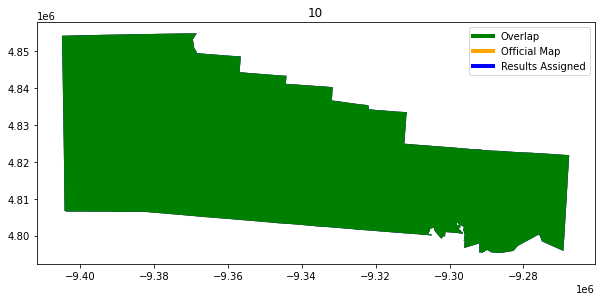

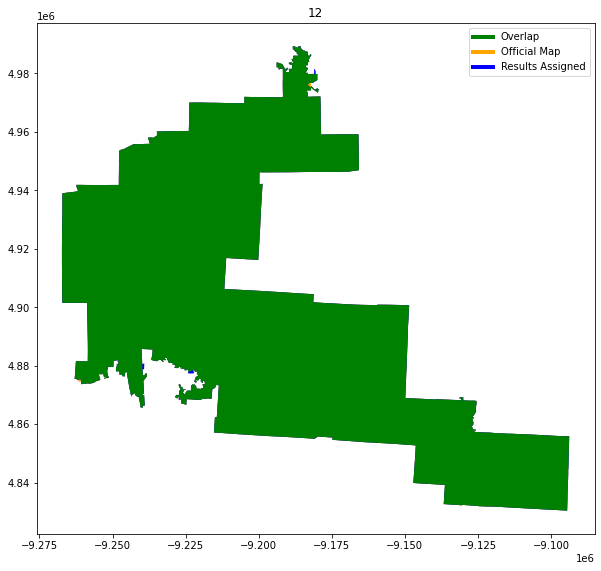

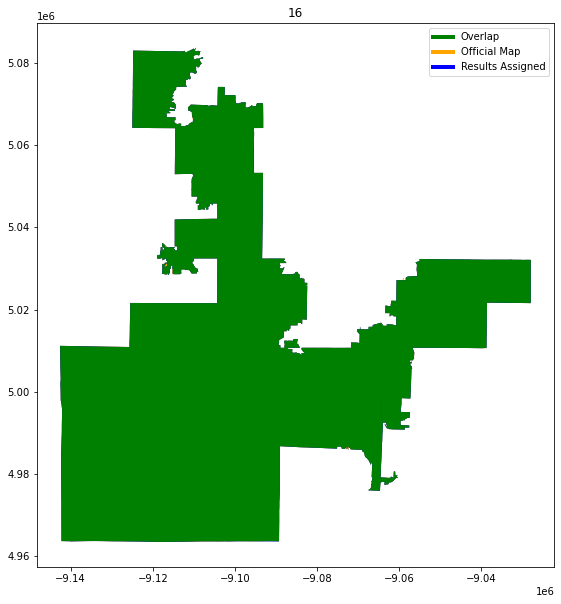

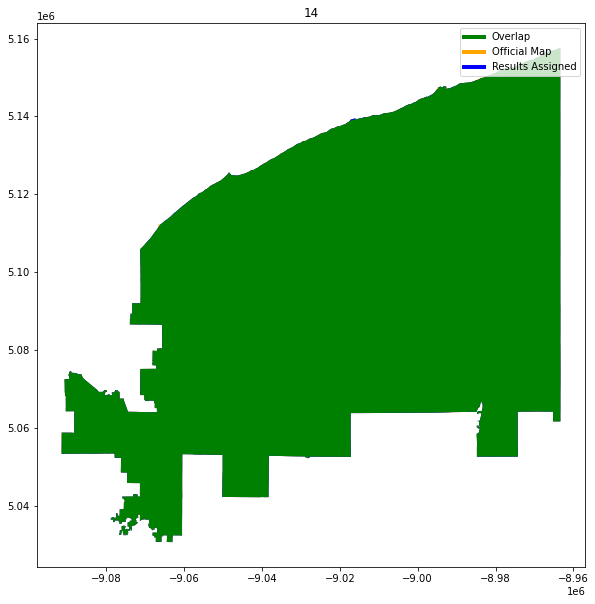

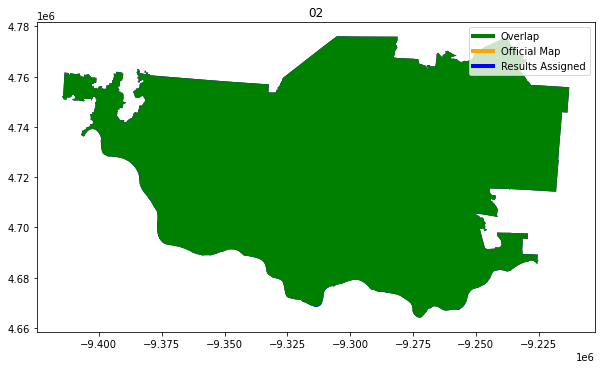

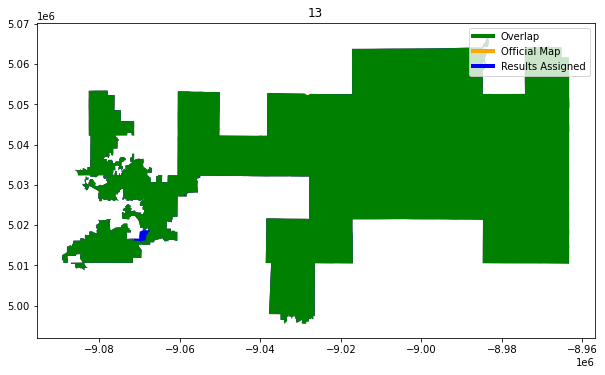

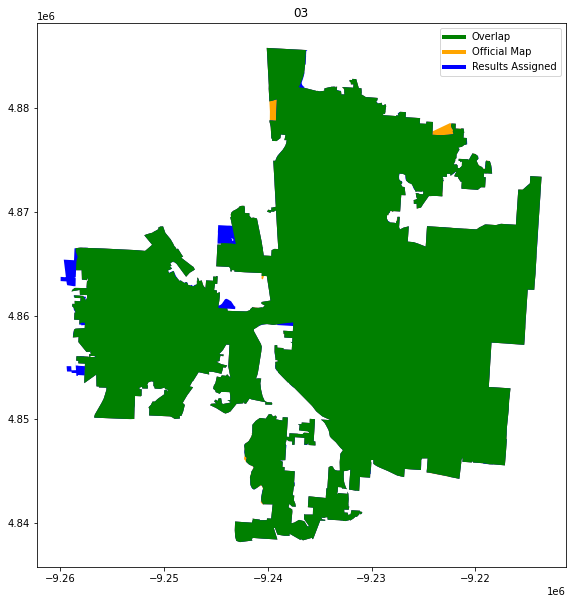

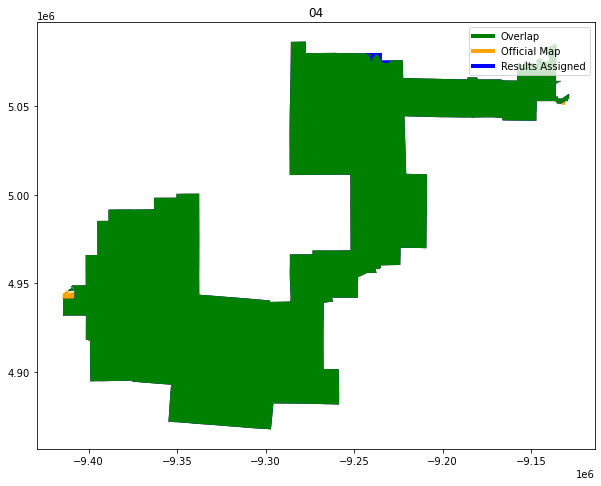

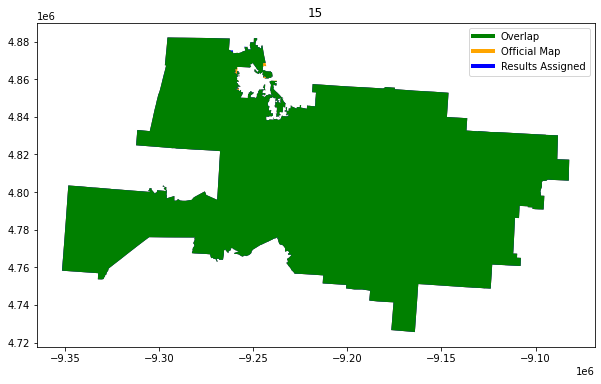

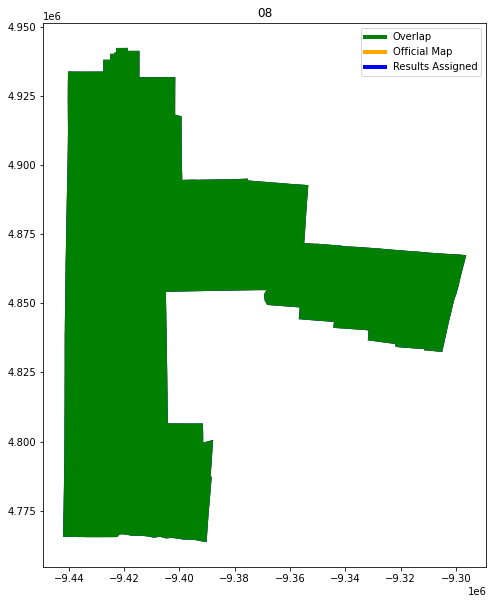

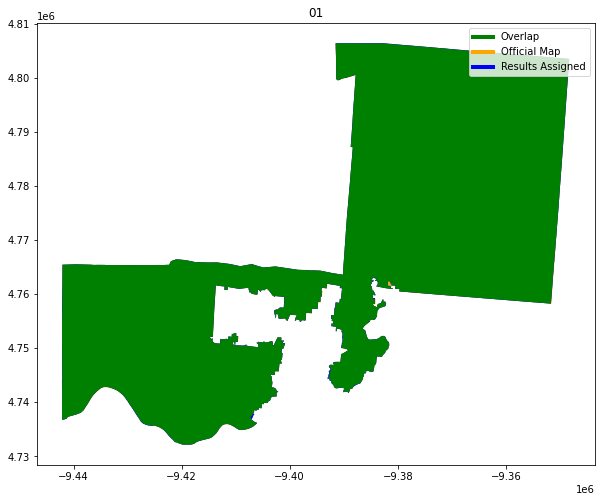

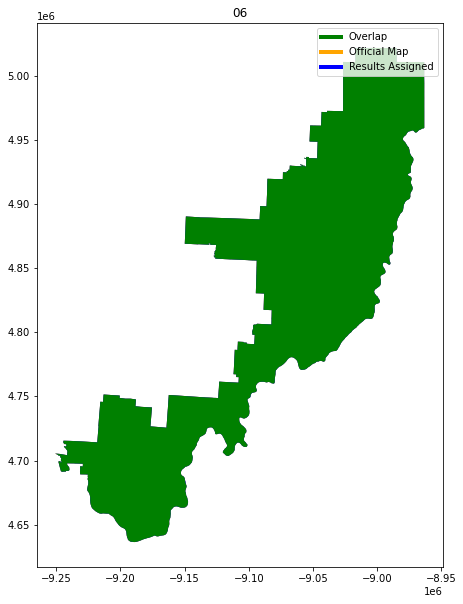

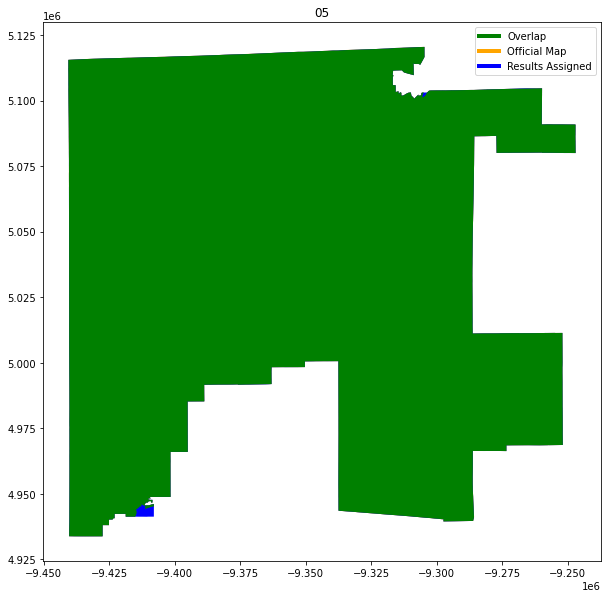

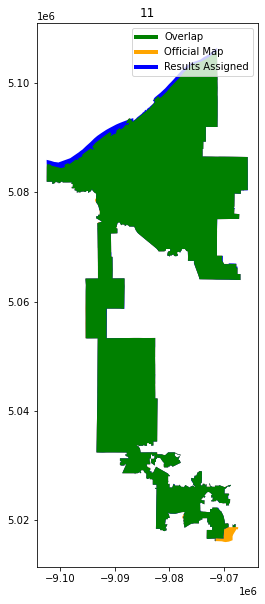

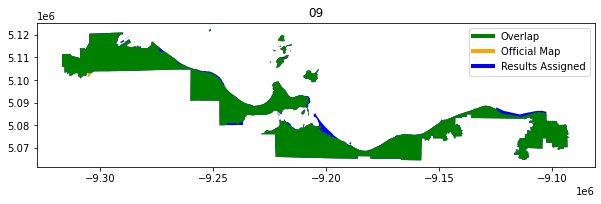

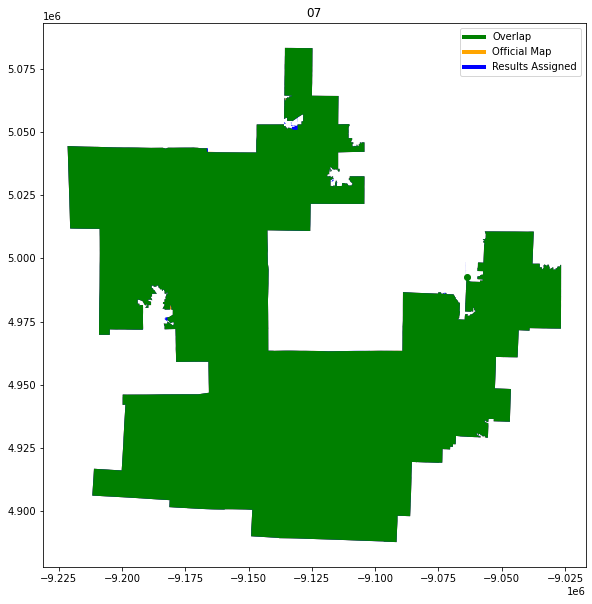

In [60]:
compare_geometries(oh_con_districts,filtered_results,"Official Map","Results Assigned","CONG_DIST",area_threshold=.1)

## Sort the columns to match what VEST has

In [61]:
vest_oh_20.columns

Index(['STATEFP20', 'COUNTYFP20', 'VTDST20', 'PRECINCT20', 'GEOID20', 'NAME20',
       'G20PRERTRU', 'G20PREDBID', 'G20PRELJOR', 'G20PREGHAW', 'geometry',
       'UNIQUE_ID'],
      dtype='object')

In [62]:
attempt_one.columns

Index(['STATEFP20', 'COUNTYFP20', 'VTDST20', 'PRECINCT20', 'GEOID20', 'NAME20',
       'G20PRERTRU', 'G20PREDBID', 'G20PRELJOR', 'G20PREGHAW', 'geometry',
       'UNIQUE_ID', 'County Name', 'Precinct Name', 'Precinct Code',
       'Region Name', 'Media Market', 'Registered Voters', 'Ballots Counted',
       'Official Voter Turnout', 'COUNTYFP', 'GCON01RCHA', 'GCON01LKAH',
       'GCON01DSCH', 'GCON02DCAS', 'GCON02RWEN', 'GCON03DBEA', 'GCON03RRIC',
       'GCON04DFRE', 'GCON04RJOR', 'GCON04LPER', 'GCON05RLAT', 'GCON05DRUB',
       'GCON06RJOH', 'GCON06DROB', 'GCON07RGIB', 'GCON07LLAP', 'GCON07DPOT',
       'GCON08RDAV', 'GCON08DENO', 'GCON09DKAP', 'GCON09RWEB', 'GCON10DTIM',
       'GCON10RTUR', 'GCON11DFUD', 'GCON11RGOR', 'GCON12RBAL', 'GCON12DSHE',
       'GCON12LSTE', 'GCON13LFRI', 'GCON13RHAG', 'GCON13DRYA', 'GCON14RJOY',
       'GCON14DMUE', 'GCON15DNEW', 'GCON15RSTI', 'GCON16DGOD', 'GCON16RGON',
       'CONG_DIST'],
      dtype='object')

In [63]:
attempt_one.rename(columns={'Registered Voters':'REG_VOTERS'},inplace=True)

In [64]:
attempt_one = attempt_one[['UNIQUE_ID','COUNTYFP','STATEFP20', 'COUNTYFP20', 'VTDST20', 'PRECINCT20', 'GEOID20',"CONG_DIST",
                           'GCON01RCHA', 'GCON01LKAH',
       'GCON01DSCH', 'GCON02DCAS', 'GCON02RWEN', 'GCON03DBEA', 'GCON03RRIC',
       'GCON04DFRE', 'GCON04RJOR', 'GCON04LPER', 'GCON05RLAT', 'GCON05DRUB',
       'GCON06RJOH', 'GCON06DROB', 'GCON07RGIB', 'GCON07LLAP', 'GCON07DPOT',
       'GCON08RDAV', 'GCON08DENO', 'GCON09DKAP', 'GCON09RWEB', 'GCON10DTIM',
       'GCON10RTUR', 'GCON11DFUD', 'GCON11RGOR', 'GCON12RBAL', 'GCON12DSHE',
       'GCON12LSTE', 'GCON13LFRI', 'GCON13RHAG', 'GCON13DRYA', 'GCON14RJOY',
       'GCON14DMUE', 'GCON15DNEW', 'GCON15RSTI', 'GCON16DGOD', 'GCON16RGON','geometry']]

In [65]:
if not os.path.exists('./oh_gen_20_prec/'):
    os.mkdir('./oh_gen_20_prec/')

attempt_one.to_file('./oh_gen_20_prec/oh_gen_20_cong_prec.shp')